In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from PIL import ImageColor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_Columns', 100)

In [2]:
color = pd.read_csv('../input/color.csv')
color_rgb = pd.DataFrame(color['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                         columns=['color_r', 'color_g', 'color_b'])
color = pd.concat([color, color_rgb], axis=1)
print('color', color.shape)

color (73636, 6)


In [3]:
palette = pd.read_csv('../input/palette.csv')
print('palette', palette.shape)
material = pd.read_csv('../input/material.csv')
print('material', material.shape)
object_collection = pd.read_csv('../input/object_collection.csv')
print('object_collection', object_collection.shape)
technique = pd.read_csv('../input/technique.csv')
print('technique', technique.shape)
maker = pd.read_csv('../input/maker.csv')
print('maker', maker.shape)
principal_maker = pd.read_csv('../input/principal_maker.csv')
print('principal_maker', principal_maker.shape)
principal_maker_occupation = pd.read_csv('../input/principal_maker_occupation.csv')
print('principal_maker_occupation', principal_maker_occupation.shape)
train = pd.read_csv('../input/train.csv')
print('train', train.shape)
test = pd.read_csv('../input/test.csv')
print('test', test.shape)
whole = pd.concat([train, test])
print('whole', whole.shape)

palette (527890, 5)
material (35394, 2)
object_collection (14210, 2)
technique (20481, 2)
maker (3291, 6)
principal_maker (24538, 6)
principal_maker_occupation (25372, 2)
train (12026, 19)
test (12008, 18)
whole (24034, 19)


In [4]:
def create_numeric_feature(df_input):
    cp = df_input.copy()
    cp['acquisition_year'] = pd.to_datetime(df_input['acquisition_date']).dt.year
    return cp[['acquisition_year', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late']]

In [5]:
def create_count_encoding_feature_sub(df_whole, df_input, column):
    cp = df_input.copy()
    newcol = 'CE_'+column
    group = df_whole.groupby(column).size().rename(newcol)
    group = pd.DataFrame(group).reset_index()
    cp = pd.merge(cp, group, on=column, how='left')
    return cp[[newcol]].fillna(0)

In [6]:
def create_count_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method', 'dating_sorting_date']
    cp = df_input.copy()
    org_col = cp.columns
    for col in col_list:
        tmp = create_count_encoding_feature_sub(whole, cp, col)
        cp = pd.concat([cp, tmp], axis=1)
    return cp.drop(columns=org_col)

In [7]:
def create_label_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method']
    cp = df_input.copy()
    org_col = cp.columns
    le = LabelEncoder()
    for col in col_list:
        le.fit(whole[col])
        cp[col] = le.transform(cp[col])
    return cp[col_list]

In [8]:
def create_all_feature(df_input):
    func_list = [
        create_numeric_feature,
        create_count_encoding_feature,
        create_label_encoding_feature,
    ]
    out = pd.DataFrame(index=df_input.index)
    for func in func_list:
        out = pd.concat([out, func(df_input)], axis=1)
        
    assert len(df_input) == len(out)
    return out

In [9]:
def split_train_target(df_input):
    target = df_input[['likes']].copy()
    target['target'] = target['likes'].apply(lambda x: np.log1p(x))
    return target['target']

In [10]:
train_X = create_all_feature(train)
test_X = create_all_feature(test)
train_y = split_train_target(train)
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
feat_cnt = len(train_X.columns)

(12026, 16)
(12026,)
(12008, 16)


In [11]:
LGBM_PARAM = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
    'max_depth' : 6,
    'verbosity': -1
}
KFOLD = 4

In [12]:
def train_kfold(X, y, params=LGBM_PARAM, k_fold=KFOLD):
    rmse_list = []
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    kf = KFold(n_splits=k_fold, shuffle=True, random_state=0)
    for train_index, valid_index in kf.split(X):

        x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        lgbm_model = lgbm.train(params, 
                                                lgbm_train, 
                                                valid_sets=lgbm_eval,
                                                num_boost_round=10000,
                                                early_stopping_rounds=100,
                                                verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        oof_pred[valid_index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        rmse_list.append(rmse)
        models.append(lgbm_model)

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('- TRAIN RMSE={:.4f}'.format(score))

    return models, oof_pred, score

In [13]:
def predict_test(test_X, models):
    pred_list = []
    for model in models:
        pred = model.predict(test_X, num_iteration = model.best_iteration)
        pred_list.append(pred)
    pred_test = np.mean(pred_list, axis=0)
    return pred_test

In [14]:
models, oof_pred, score = train_kfold(train_X, train_y)

train_pred = np.expm1(oof_pred)
train_pred[train_pred < 0] = 0

train_target = pd.DataFrame(index=train_X.index)
train_target['target'] = train_y
train_target['log_pred'] = oof_pred
train_target['likes'] = train['likes']
train_target['pred'] = train_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's rmse: 1.17959
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's rmse: 1.26964
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 1.19072
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2

In [15]:
pred = predict_test(test_X, models)

test_pred = np.expm1(pred)
test_pred[test_pred < 0] = 0
df_test_pred = pd.DataFrame(test_pred, columns=['likes'])
assert len(df_test_pred) == len(test)

In [16]:
df_test_pred.to_csv('../output/submit.csv', index=False)

In [17]:
df_test_pred.head()

,likes
0,0.490416
1,27.628783
2,0.717185
3,5.485818
4,1.018684


In [18]:
train_target.head()

,target,log_pred,likes,pred
0,3.891820,4.752441,48,114.866723
1,1.098612,1.585635,2,3.882392
2,1.791759,1.131691,5,2.100896
3,4.615121,3.206697,100,23.697385
4,2.079442,3.248398,7,24.749061


In [19]:
def plot_scatter(data1):
    x1 = data1['target']
    y1 = data1['log_pred']
    xmax = max(max(x1), max(y1))*1.05
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x1, y1, alpha=0.3, marker='.')
    ax.plot([0, xmax], [0, xmax], color='black', linewidth=0.5)
    plt.xlabel('target')
    plt.ylabel('pred')
    plt.xlim(0, xmax)
    plt.ylim(0, xmax)

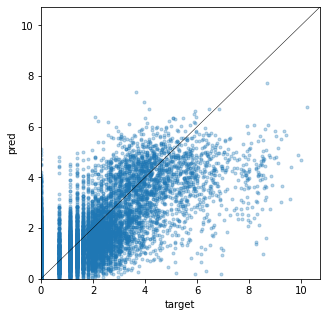

In [20]:
corr = train_target[['target', 'log_pred']].corr().iat[0,1]
plot_scatter(train_target)

In [21]:
print('- feat_cnt =', feat_cnt)
print(f'- score = {score:.5f}')
print(f'- corr = {corr:.5f}')

- feat_cnt = 16
- score = 1.20651
- corr = 0.73332


#### baseline_0
- feat_cnt = 16
- score = 1.20651
- corr = 0.73332
- LB = 1.1827

In [22]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

def draw_feature_importance(fi):
    fi_plot = fi.head(20).sort_values('sum', ascending=True)
    X = np.arange(len(fi_plot))
    plt.figure(figsize=(5, 7))
    plt.barh(X, fi_plot['sum'], tick_label=fi_plot['name'])
    plt.title('Feature Importance')

In [23]:
fi = feature_importance(models)
fi

,name,imp_0,imp_1,imp_2,imp_3,sum
15,acquisition_year,1059,1270,1313,1155,4797
14,art_series_id,939,1138,1261,939,4277
13,principal_maker,784,901,956,820,3461
11,dating_year_late,730,937,962,779,3408
12,dating_sorting_date,765,831,921,775,3292
9,CE_dating_sorting_date,638,748,895,707,2988
10,CE_principal_maker,680,695,727,604,2706
8,CE_acquisition_method,236,212,235,235,918
7,acquisition_method,162,159,188,150,659
6,CE_principal_or_first_maker,127,153,146,126,552


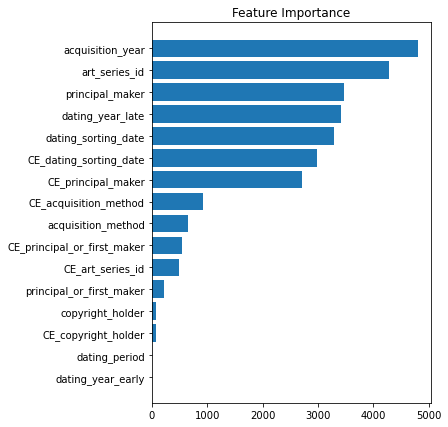

In [24]:
draw_feature_importance(fi)